In [1]:
%cd ..

/home/sheik_dawood/Workspace/compoundGAN


In [2]:
import torch
import networkx as nx
from rdkit import Chem

from data.zinc import mol2graph, Library

from models.encoder import Encoder
from models.generator import Generator

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
state_dict = torch.load('/storage/sheik_dawood/Experiments/compoundGAN/compound-gan-4b4b151e64fc42bba40a808dc5ab74bf/model_1.weights')

In [15]:
enc = Encoder(59, 13, 256)
enc = enc.cuda()
enc.load_state_dict(state_dict['enc_state_dict'])
enc = enc.eval()

gen = Generator(256, [44, 7, 3, 3, 2], [5, 2, 2, 4])
gen = gen.cuda()
gen.load_state_dict(state_dict['gen_state_dict'])
gen = gen.eval()

In [29]:
smiles = 'C1=CC=CC=C1'
smiles = 'C'
#smiles = 'CCOc1ccc(OCC)c([C@H]2C(C#N)=C(N)N(c3ccccc3C(F)(F)F)C3=C2C(=O)CCC3)c1'
mol = Chem.MolFromSmiles(smiles)
G, atom_feats, bond_feats = mol2graph(mol)

In [30]:
G.to(torch.device('cuda:0'))
mu, var = enc(G)
z = mu#enc.reparameterize(mu, var)
print(z.data.cpu().numpy())

[ 2.66626644e+00  2.52527595e+00  2.18058109e+00 -2.91135192e+00
  2.33203077e+00 -3.83731771e+00  3.20259404e+00  2.30792356e+00
 -2.15235686e+00  2.31993236e-02 -1.25894213e+00 -2.49840952e-02
  1.51957917e+00  3.70045519e+00 -3.40808779e-01 -1.69535175e-01
 -1.06404208e-01  4.24374914e+00 -1.16790259e+00 -9.07069221e-02
  4.98436242e-01  1.22746266e-02 -1.39894724e+00 -2.07910919e+00
  7.17206299e-01  7.71020055e-02  4.01212788e+00  1.41409135e+00
  7.67775118e-01  2.75860476e+00  2.07487926e-01 -1.59516847e+00
 -3.13718891e+00 -5.33593476e-01  1.50904155e+00  6.69399798e-01
 -3.72556783e-03  2.25053406e+00  6.07070290e-02  3.44817564e-02
 -2.06377077e+00  4.05852906e-02  2.22788191e+00  4.03080511e+00
 -2.94905044e-02  2.07710385e+00  1.79892111e+00 -1.74791479e+00
  8.39525983e-02 -2.46402335e+00 -5.02612948e-01  3.06327558e+00
 -1.00894427e+00  3.38463783e-01 -3.97751617e+00  2.61718106e+00
  9.00799036e-02 -2.63028669e+00 -1.01636422e+00  3.01507378e+00
 -1.11002088e+00 -7.87283

In [31]:
node_list, edge_list = gen(z.unsqueeze(0), 100)

In [32]:
nodes = []
edges = []
for i, node in enumerate(node_list):
    n = []
    n.append(Library.atom_list[node[0][0].data.cpu().numpy()[0]])
    n.append(Library.charge_list[node[1][0].data.cpu().numpy()[0]])
    n.append(Library.electron_list[node[2][0].data.cpu().numpy()[0]])
    try:
        n.append(Library.chirality_list[node[3][0].data.cpu().numpy()[0]])
    except IndexError:
        n.append('')
    nodes.append(n[0])
    
    e = []
    _edges = edge_list[i]
    for j, edge in enumerate(_edges):
        idx = edge[0][0].data.cpu().numpy()[0]
        if idx == 0:
            continue
        e.append((idx, j))
        edges.append((j, i))

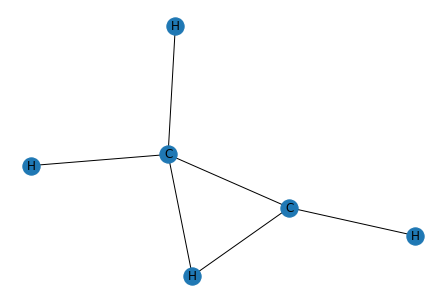

In [33]:
predicted = nx.Graph()
for i, n in enumerate(nodes):
    predicted.add_node(i, atom=n)
for e in edges:
    predicted.add_edge(*e)

plt.figure()
pos = nx.kamada_kawai_layout(predicted)
nx.draw(predicted, pos)
node_labels = nx.get_node_attributes(predicted,'atom')
nx.draw_networkx_labels(predicted, pos, labels=node_labels)
plt.show()